In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Images.zip"

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

In [4]:
import os
import glob
import random
import shutil

# Define standard naming convention
standard_prefix_advertising = "advertising"
standard_prefix_non_advertising = "non_advertising"

# Function to rename images in a folder
def rename_images(folder, standard_prefix):
    img_files = glob.glob(os.path.join(folder, "*.jpg"))
    for i, img_file in enumerate(img_files):
        new_filename = f"{standard_prefix}_{i}.jpg"
        new_filepath = os.path.join(folder, new_filename)
        os.rename(img_file, new_filepath)

# Rename advertising images
advertising_folder = "Images/Advertising Images"
rename_images(advertising_folder, standard_prefix_advertising)

# Rename non-advertising images
non_advertising_folder = "Images/Non-Advertising Images"
rename_images(non_advertising_folder, standard_prefix_non_advertising)

# Load all advertising images and randomly select 2500
advertising_images = glob.glob(os.path.join(advertising_folder, "*.jpg"))
random.shuffle(advertising_images)
selected_advertising_images = advertising_images[:2500]

# Combine selected advertising images with all non-advertising images
all_images = selected_advertising_images + glob.glob(os.path.join(non_advertising_folder, "*.jpg"))
random.shuffle(all_images)

print("Total number of images:", len(all_images))


Total number of images: 3166


In [5]:
all_images[20:50]

['Images/Advertising Images/advertising_3089.jpg',
 'Images/Advertising Images/advertising_1192.jpg',
 'Images/Advertising Images/advertising_3566.jpg',
 'Images/Advertising Images/advertising_1040.jpg',
 'Images/Advertising Images/advertising_1044.jpg',
 'Images/Non-Advertising Images/non_advertising_82.jpg',
 'Images/Advertising Images/advertising_4740.jpg',
 'Images/Advertising Images/advertising_3348.jpg',
 'Images/Advertising Images/advertising_246.jpg',
 'Images/Advertising Images/advertising_584.jpg',
 'Images/Advertising Images/advertising_3439.jpg',
 'Images/Advertising Images/advertising_2476.jpg',
 'Images/Advertising Images/advertising_244.jpg',
 'Images/Advertising Images/advertising_24.jpg',
 'Images/Non-Advertising Images/non_advertising_379.jpg',
 'Images/Advertising Images/advertising_125.jpg',
 'Images/Non-Advertising Images/non_advertising_528.jpg',
 'Images/Advertising Images/advertising_3887.jpg',
 'Images/Advertising Images/advertising_1647.jpg',
 'Images/Non-Adve

In [6]:
import cv2
import numpy as np
import imgaug.augmenters as iaa
from sklearn.utils import shuffle

# To define augmentation sequence
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),        # horizontally flip 50% of images
    iaa.Flipud(0.5),        # vertically flip 50% of images
    iaa.Rotate((-20, 20)),  # rotate images by -20 to +20 degrees
    iaa.GaussianBlur(sigma=(0, 1.0))  # apply gaussian blur
])

# Function to preprocess and augment images
def preprocess_images(image_paths, target_size=(224, 224), normalize=True, augmentation=None):
    images = []
    for image_path in image_paths:
        # Load image
        image = cv2.imread(image_path)
        # Resize image
        image = cv2.resize(image, target_size)
        # Augment image
        if augmentation is not None:
            image = augmentation(image=image)
        # Convert image to float32
        image = image.astype(np.float32)
        # Normalize image
        if normalize:
            image /= 255.0  # Normalize pixel values to [0, 1]
        images.append(image)
    return np.array(images)

# Preprocess and augment all images
X = preprocess_images(all_images, augmentation=augmentation)  # Preprocess and augment images

# To Check the shape of the preprocessed images array
print("Shape of preprocessed images array:", X.shape)


Shape of preprocessed images array: (3166, 224, 224, 3)


In [7]:
from sklearn.preprocessing import LabelEncoder

# Extract category labels from file names
def extract_labels(file_paths):
    labels = []
    for file_path in file_paths:
        label = file_path.split("/")[-2]  # Extract label from file path
        labels.append(label)
    return labels

# Encode category labels using LabelEncoder
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder.classes_

# Get category labels
labels = extract_labels(all_images)

# Encode category labels
y_encoded, classes = encode_labels(labels)

# Print the encoded labels and their corresponding classes
print("Encoded labels:", len(y_encoded))
print("Corresponding classes:", classes)


Encoded labels: 3166
Corresponding classes: ['Advertising Images' 'Non-Advertising Images']


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert lists to NumPy arrays
all_images = np.array(all_images)
y_encoded = np.array(y_encoded)

# Split the dataset into training, testing, and validation sets
# First, split into training and temporary sets (80% training, 20% temporary)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Second, split the temporary set into testing and validation sets (50% testing, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train_temp.shape, y_train_temp.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Training set shape: (2532, 224, 224, 3) (2532,)
Testing set shape: (317, 224, 224, 3) (317,)
Validation set shape: (317, 224, 224, 3) (317,)


In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Define batch size for incremental scaling
batch_size = 500

# Initialize empty arrays to store scaled data
X_train_scaled = np.empty_like(X_train_temp)
X_test_scaled = np.empty_like(X_test)
X_val_scaled = np.empty_like(X_val)

# Incrementally scale training data
for i in range(0, len(X_train_temp), batch_size):
    batch_X_train = X_train_temp[i:i+batch_size]
    batch_X_train_flat = batch_X_train.reshape(batch_X_train.shape[0], -1)
    scaler.partial_fit(batch_X_train_flat)
    batch_X_train_scaled = scaler.transform(batch_X_train_flat)
    X_train_scaled[i:i+batch_size] = batch_X_train_scaled.reshape(batch_X_train.shape)

# Incrementally scale testing data
for i in range(0, len(X_test), batch_size):
    batch_X_test = X_test[i:i+batch_size]
    batch_X_test_flat = batch_X_test.reshape(batch_X_test.shape[0], -1)
    batch_X_test_scaled = scaler.transform(batch_X_test_flat)
    X_test_scaled[i:i+batch_size] = batch_X_test_scaled.reshape(batch_X_test.shape)

# Incrementally scale validation data
for i in range(0, len(X_val), batch_size):
    batch_X_val = X_val[i:i+batch_size]
    batch_X_val_flat = batch_X_val.reshape(batch_X_val.shape[0], -1)
    batch_X_val_scaled = scaler.transform(batch_X_val_flat)
    X_val_scaled[i:i+batch_size] = batch_X_val_scaled.reshape(batch_X_val.shape)

# Print the shape of the scaled data
print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled testing data:", X_test_scaled.shape)
print("Shape of scaled validation data:", X_val_scaled.shape)


Shape of scaled training data: (2532, 224, 224, 3)
Shape of scaled testing data: (317, 224, 224, 3)
Shape of scaled validation data: (317, 224, 224, 3)


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer with a dropout rate of 0.5
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


58889256/58889256 [==============================] - 2s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]
# Train the model
history = model.fit(X_train_scaled, y_train_temp,
                    epochs=20,
                    batch_size=128,  # Increased batch size
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Evaluate the model on validation data
loss, accuracy = model.evaluate(X_val_scaled, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.7658

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 63s 2s/step - loss: 0.8851 - accuracy: 0.7658 - val_loss: 0.2621 - val_accuracy: 0.8896
Epoch 2/20
20/20 [==============================] - 11s 539ms/step - loss: 0.2125 - accuracy: 0.9230 - val_loss: 0.3334 - val_accuracy: 0.8580
Epoch 3/20
20/20 [==============================] - 11s 550ms/step - loss: 0.1268 - accuracy: 0.9546 - val_loss: 0.3222 - val_accuracy: 0.8549
Epoch 4/20
20/20 [==============================] - 14s 687ms/step - loss: 0.0892 - accuracy: 0.9680 - val_loss: 0.1705 - val_accuracy: 0.9274
Epoch 5/20
20/20 [==============================] - 12s 628ms/step - loss: 0.0754 - accuracy: 0.9767 - val_loss: 0.2755 - val_accuracy: 0.8959
Epoch 6/20
20/20 [==============================] - 11s 568ms/step - loss: 0.0511 - accuracy: 0.9830 - val_loss: 0.2170 - val_accuracy: 0.9274
Epoch 7/20
10/10 [==============================] - 14s 823ms/step - loss: 0.1157 - accuracy: 0.9590
Validation Loss: 0.11566618084907532
Validation Accurac

In [12]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


10/10 [==============================] - 1s 128ms/step - loss: 0.0718 - accuracy: 0.9716
Test Loss: 0.07176938652992249
Test Accuracy: 0.9716088175773621


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

pScore = precision_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("F1-score: ", fScore)

10/10 [==============================] - 1s 124ms/step
Precision:  0.9719281771798679
Recall:  0.9716088328075709
F1-score:  0.9710223933168827


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


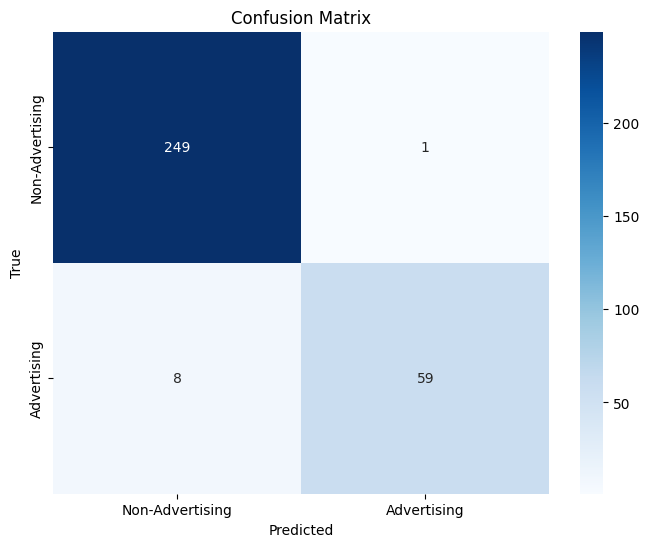

In [15]:
# To plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['Non-Advertising', 'Advertising'])

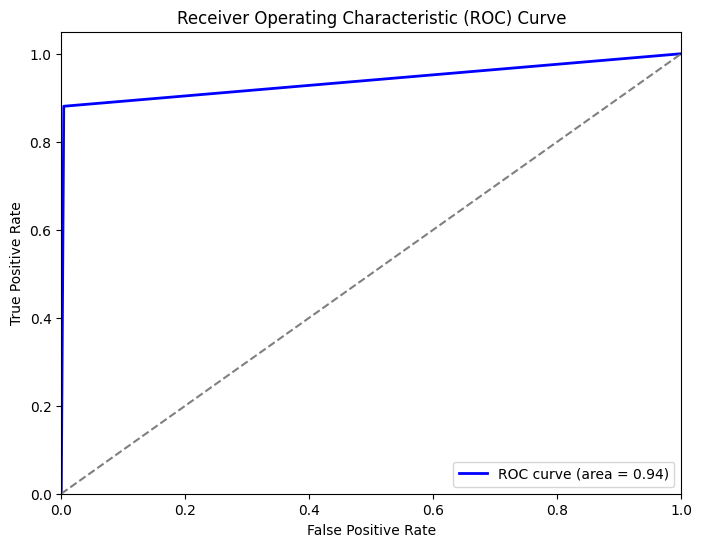

In [16]:
# To plot ROC curve
plot_roc_curve(y_test, y_pred)

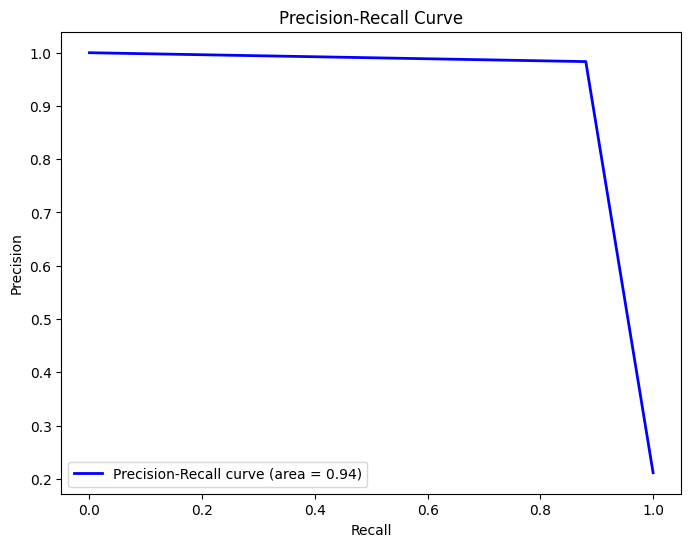

In [17]:
# To plot precision-recall curve
plot_precision_recall_curve(y_test, y_pred)

In [18]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00


553467096/553467096 [==============================] - 16s 0us/step


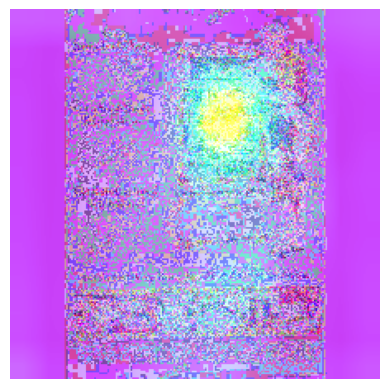

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Load and preprocess the image
img_path = "Images/Advertising Images/advertising_2050.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Initialize Grad-CAM explainer
explainer = GradCAM()

# Explain the model's prediction using Grad-CAM with block5_conv3 layer
grid = explainer.explain((img_array, None), model, class_index=1, layer_name="block5_conv3")

# Visualize the Grad-CAM heatmap
plt.imshow(grid)
plt.axis('off')
plt.show()


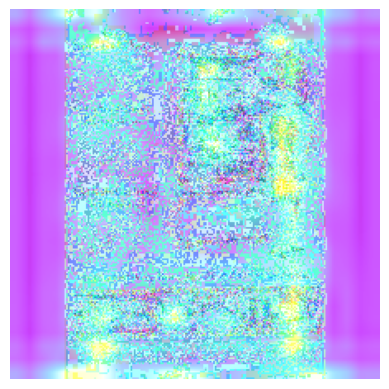

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tf_explain.core.grad_cam import GradCAM

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Load and preprocess the image
img_path = "Images/Advertising Images/advertising_2050.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Initialize Grad-CAM explainer
explainer = GradCAM()

# Explain the model's prediction using Grad-CAM with block4_conv3 layer
grid = explainer.explain((img_array, None), model, class_index=1, layer_name="block4_conv3")

# Visualize the Grad-CAM heatmap
plt.imshow(grid)
plt.axis('off')
plt.show()


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

img_path = 'Images/Advertising Images/advertising_3310.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features from a specific layer of the pre-trained model
layer_name = 'block4_pool'
intermediate_layer_model = Model(inputs=base_model.input,
                                 outputs=base_model.get_layer(layer_name).output)

# Get the feature vector
feature_vector = intermediate_layer_model.predict(x)

print("Shape of feature vector:", feature_vector.shape)


1/1 [==============================] - 1s 1s/step
Shape of feature vector: (1, 14, 14, 512)


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Multiply, Input
from tensorflow.keras.models import Model


feature_dim = 512  # Assuming a feature dimension of 512
feature_vector = Input(shape=(feature_dim,))

# Add attention mechanism
attention_probs = Dense(units=1, activation='softmax')(feature_vector)
attention_mul = Multiply()([feature_vector, attention_probs])

# Add classification layer on top of attention output
num_classes = 2
predictions = Dense(num_classes, activation='softmax')(attention_mul)

# Create the model
updated_model = Model(inputs=feature_vector, outputs=predictions)

# Compile the model
updated_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
updated_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 1)                    513       ['input_5[0][0]']             
                                                                                                  
 multiply (Multiply)         (None, 512)                  0         ['input_5[0][0]',             
                                                                     'dense_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 2)                    1026      ['multiply[0][0]']      

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Multiply, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Function to preprocess input image and extract features
def preprocess_and_extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x)
    features = Flatten()(features)  # Flatten the features into a 1D array
    return features

img_paths = ['Images/Check_Images/Ads_Image_101.jpg', 'Images/Check_Images/Non-Ads_Image_101.jpg','Images/Check_Images/Ads_Image_201.jpg','Images/Check_Images/Non-Ads_Image_201.jpg']

# Preprocess input images and extract features
X_train = np.array([preprocess_and_extract_features(img_path) for img_path in img_paths])
X_train = np.squeeze(X_train)

# Define labels (assuming binary classification)
y_train = np.array([1,0,1,0])  # Example labels

# Define the model architecture
feature_dim = 25088  # Feature dimension after flattening
feature_vector = Input(shape=(feature_dim,))
attention_probs = Dense(units=1, activation='softmax')(feature_vector)
attention_mul = Multiply()([feature_vector, attention_probs])
num_classes = 2  # Example number of classes
predictions = Dense(num_classes, activation='softmax')(attention_mul)
attMec_model = Model(inputs=feature_vector, outputs=predictions)

# Compile the model
attMec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
attMec_model.summary()


1/1 [==============================] - 0s 18ms/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 25088)]              0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 1)                    25089     ['input_7[0][0]']             
                                                                                                  
 multiply_1 (Multiply)       (None, 25088)                0         ['input_7[0][0]',             
                                                                     'dense_6[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 2)  

In [24]:
print(X_train_scaled.shape)
print(y_train_temp.shape)

(2532, 224, 224, 3)
(2532,)


In [27]:
history = attMec_model.fit(X_train, y_train,
                            epochs=10,
                            batch_size=128)

Epoch 1/10
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accura